In [1]:
### importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
import shutil
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import PIL
from PIL import Image, ImageDraw, ImagePath

## Dataset Overview -
### We have taken Marmot dataset which contains scanned images alongside their respective .xml file which contains the information about table and column coordinates . It is a public dataset that is freely usable for research purposes . 

## Real World/Business objectives and constraints - 

### 1. High accuracy between the ground truth table and column mask and the predicted masks
### 2. Maximize precision and recall
### 3.Column and table mask prediciton should happen in a few seconds and user shouldn't have to wait for long.

In [2]:
os.chdir('D:/Applied AI/Case study 2/Marmot_data')

In [7]:
path = os.listdir()[0]
print (path)

10.1.1.1.2006_3.bmp


In [11]:
image = cv.imread(path)

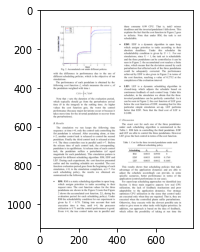

In [12]:
plt.imshow(image)

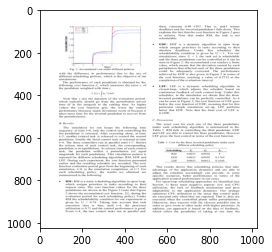

In [13]:
image = cv.resize(image, (1024,1024), interpolation = cv.INTER_AREA)
plt.imshow(image)

### A sample of the scanned image

### Our first step is to create dataset from all the images and their respective xml files . We will create two directories , one for image and one for mask 

In [39]:
all_files = []
for i in os.listdir():
    if i[-3:] == 'bmp':
        file = i.split('.bmp')
        file = ''.join(file)
        all_files.append(file)

In [40]:
all_files[:6]

['10.1.1.1.2006_3',
 '10.1.1.1.2010_5',
 '10.1.1.1.2013_63',
 '10.1.1.1.2013_64',
 '10.1.1.1.2014_4',
 '10.1.1.1.2014_6']

In [41]:
len(all_files)

509

### We have got the names of all the files . Now we will create two separate directories for images and mask

In [42]:
root_dir = 'D:/Applied AI/Case study 2'

In [54]:
os.mkdir(os.path.join(root_dir, 'images'))

image_dir = os.path.join(root_dir, 'images/')

for file in os.listdir() :
    if file[-3:] == 'bmp' :
        original_path = os.path.join(root_dir, 'Marmot_data/', file)
        destination = os.path.join(image_dir, file)
        shutil.move(original_path, destination)

In [57]:
os.mkdir(os.path.join(root_dir, 'mask'))

mask_dir = os.path.join(root_dir, 'mask/')

for file in os.listdir():
    if file[-3:] == 'xml' :
        original_path = os.path.join(root_dir, 'Marmot_data/', file)
        destination = os.path.join(mask_dir, file)
        shutil.move(original_path, destination)

### Now we will create a pandas dataframe. But first we have to check whether we have annotation file for every image

In [60]:
len_image_dir = len(os.listdir(image_dir))

len_mask_dir = len(os.listdir(mask_dir))

print ("No of files in image directory are {}".format(len_image_dir))
print ("No of files in mask directory are {}".format(len_mask_dir))

No of files in image directory are 509
No of files in mask directory are 495


### 14 annotation files are missing from the original dataset. We will remove those image files

In [114]:
### creating a dataframe

dataset = pd.DataFrame()

files = []

for i in os.listdir(image_dir) :
    for j in os.listdir(mask_dir) :
        image = i.split('.bmp')[0]
        mask = j.split('.xml')[0]
        if image == mask :
            obj = (os.path.join('Case study 2/images/',i),os.path.join('Case study 2/mask/',j))
            files.append(obj)

In [115]:
files[:3]

[('Case study 2/images/10.1.1.1.2006_3.bmp',
  'Case study 2/mask/10.1.1.1.2006_3.xml'),
 ('Case study 2/images/10.1.1.1.2013_63.bmp',
  'Case study 2/mask/10.1.1.1.2013_63.xml'),
 ('Case study 2/images/10.1.1.1.2013_64.bmp',
  'Case study 2/mask/10.1.1.1.2013_64.xml')]

In [116]:
images = []
mask = []
for i in files :
    images.append(i[0])
    mask.append(i[1])
    
dataset['image'] = images
dataset['mask'] = mask

In [117]:
dataset.head()

,image,mask
0,Case study 2/images/10.1.1.1.2006_3.bmp,Case study 2/mask/10.1.1.1.2006_3.xml
1,Case study 2/images/10.1.1.1.2013_63.bmp,Case study 2/mask/10.1.1.1.2013_63.xml
2,Case study 2/images/10.1.1.1.2013_64.bmp,Case study 2/mask/10.1.1.1.2013_64.xml
3,Case study 2/images/10.1.1.1.2014_4.bmp,Case study 2/mask/10.1.1.1.2014_4.xml
4,Case study 2/images/10.1.1.1.2014_6.bmp,Case study 2/mask/10.1.1.1.2014_6.xml


### Next step is to read the xml file and create mask images

In [218]:
### reference - https://docs.python.org/3/library/xml.etree.elementtree.html

tree = ET.parse('10.1.1.1.2006_3.xml')

In [219]:
root = tree.getroot()

### For column mask we will take all the y and x coordinates meanwhile for table mask we will selected minimum from the ymin and xmin and the maximum from xmax and ymax 

In [222]:
ymin = []
ymax = []
xmin = []
xmax = []
for label in root.findall('object'):
    valv = label.find('bndbox')
    ymin.append(valv.find('ymin').text)
    ymax.append(valv.find('ymax').text)
    xmin.append(valv.find('xmin').text)
    xmax.append(valv.find('xmax').text)

In [233]:
for size in root.findall('size'):
    h = size.find('height').text
    w = size.find('width').text

In [232]:
h

'1123'

In [234]:
w

'793'

In [236]:
col_mask = np.zeros((int(h),int(w)), dtype = np.int32)
tab_mask = np.zeros((int(h),int(w)), dtype = np.int32)

In [238]:
len(xmax)

4

In [241]:
for i in range(len(xmax)) :
    col_mask[int(ymin[i]) : int(ymax[i]), int(xmin[i]) : int(xmax[i])] = 255

In [251]:
im = Image.fromarray(col_mask)

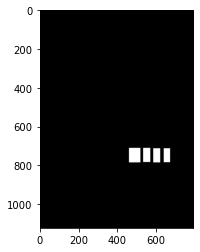

In [304]:
plt.imshow(im)

In [305]:
im.mode

'I'

In [254]:
ymin_ = int(min(ymin))

In [255]:
ymax_ = int(max(ymax))
xmin_ = int(min(xmin))
xmax_ = int(max(xmax))

In [256]:
print (ymin_, ymax_, xmin_, xmax_)

710 785 458 670


In [259]:
tab_mask = np.zeros((int(h),int(w)), dtype = np.int32)

In [260]:
tab_mask[ymin_ : ymax_ , xmin_ : xmax_] = 255

In [276]:
tb = Image.fromarray(tab_mask)

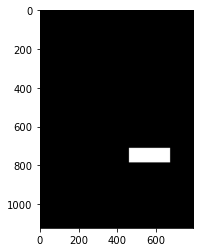

In [277]:
plt.imshow(tb)

In [278]:
if tb.mode != 'RGB' :
    tb = tb.convert('RGB')

In [280]:
tb.mode

'RGB'

In [5]:
dataset = pd.read_csv('D:/Applied AI/Case study 2/dataset.csv')

In [8]:
### creating new directory for table and column masks 
output_dir = 'output/'
root_dir = 'D:/Applied AI/Case study 2'
os.mkdir(os.path.join(root_dir, output_dir))

for mask in dataset['mask'].values :
    tree = ET.parse(os.path.join('D:/Applied AI/',mask))
    root = tree.getroot()
    ymin = []
    ymax = []
    xmin = []
    xmax = []
    for label in root.findall('object'):
        valv = label.find('bndbox')
        ymin.append(valv.find('ymin').text)
        ymax.append(valv.find('ymax').text)
        xmin.append(valv.find('xmin').text)
        xmax.append(valv.find('xmax').text)
    for size in root.findall('size'):
        h = size.find('height').text
        w = size.find('width').text
    col_mask = np.zeros((int(h),int(w)), dtype = np.int32)
    tab_mask = np.zeros((int(h),int(w)), dtype = np.int32)
    for i in range(len(xmax)) :
        col_mask[int(ymin[i]) : int(ymax[i]), int(xmin[i]) : int(xmax[i])] = 255
    ymin_ = int(min(ymin))
    ymax_ = int(max(ymax))
    xmin_ = int(min(xmin))
    xmax_ = int(max(xmax))
    tab_mask[ymin_ : ymax_ , xmin_ : xmax_] = 255
    tb = Image.fromarray(tab_mask.astype(np.uint8), 'L')
    cb = Image.fromarray(col_mask.astype(np.uint8), 'L')
    #if cb.mode != 'RGB' :
        #cb = cb.convert('RGB')
    #if tb.mode != 'RGB' :
        #tb = tb.convert('RGB')
    mask = mask.split('/')[-1]
    mask = mask.split('.xml')[0]
    os.mkdir(os.path.join(root_dir, output_dir, mask))
    filepath_tb = os.path.join(root_dir, output_dir, mask) +'/' +'table_mask' + '.jpeg'
    filepath_cb = os.path.join(root_dir, output_dir, mask) +'/' +'column_mask' + '.jpeg'
    cb.save(filepath_cb)
    tb.save(filepath_tb)

### We now have the respective table and column masks for every scanned image . Now we will append their location to our dataframe

In [308]:
dataset.head()

,image,mask
0,Case study 2/images/10.1.1.1.2006_3.bmp,Case study 2/mask/10.1.1.1.2006_3.xml
1,Case study 2/images/10.1.1.1.2013_63.bmp,Case study 2/mask/10.1.1.1.2013_63.xml
2,Case study 2/images/10.1.1.1.2013_64.bmp,Case study 2/mask/10.1.1.1.2013_64.xml
3,Case study 2/images/10.1.1.1.2014_4.bmp,Case study 2/mask/10.1.1.1.2014_4.xml
4,Case study 2/images/10.1.1.1.2014_6.bmp,Case study 2/mask/10.1.1.1.2014_6.xml


In [345]:
filenames = []
for i in dataset['mask'].values :
    name = " ".join(i.split('/')[2:])
    name = name.split('.xml')[0]
    filenames.append(name)

In [346]:
len(filenames)

494

In [409]:
column_files = []
table_files = []

root_dir = 'D:/Applied AI/Case study 2'
for i in os.listdir(os.path.join(root_dir, mask_dir)) :
    file = i.split('/')[-1]
    file = file.split('.xml')[0]
    if file in filenames :
        for k in os.listdir(os.path.join(root_dir, output_dir, file)):
            path = os.path.join(root_dir, output_dir,file, k)
            path = "/".join(path.split('/')[2:])
            if path[-15:] == 'table_mask.jpeg' :
                table_files.append(path)
            else :
                column_files.append(path)

In [410]:
print ("Length of column mask files are {} and length of table mask files are {}".format(len(column_files), len(table_files)))

Length of column mask files are 494 and length of table mask files are 494


In [412]:
### appending to our dataframe

dataset['column_output'] = column_files
dataset['table_output'] = table_files

In [413]:
dataset['column_output'] = dataset['column_output'].apply(lambda x: x.replace('\\', '/'))
dataset['table_output'] = dataset['table_output'].apply(lambda x: x.replace('\\', '/'))

In [414]:
dataset.head()

,image,mask,column_output,table_output
0,Case study 2/images/10.1.1.1.2006_3.bmp,Case study 2/mask/10.1.1.1.2006_3.xml,Case study 2/output/10.1.1.1.2006_3/column_mas...,Case study 2/output/10.1.1.1.2006_3/table_mask...
1,Case study 2/images/10.1.1.1.2013_63.bmp,Case study 2/mask/10.1.1.1.2013_63.xml,Case study 2/output/10.1.1.1.2013_63/column_ma...,Case study 2/output/10.1.1.1.2013_63/table_mas...
2,Case study 2/images/10.1.1.1.2013_64.bmp,Case study 2/mask/10.1.1.1.2013_64.xml,Case study 2/output/10.1.1.1.2013_64/column_ma...,Case study 2/output/10.1.1.1.2013_64/table_mas...
3,Case study 2/images/10.1.1.1.2014_4.bmp,Case study 2/mask/10.1.1.1.2014_4.xml,Case study 2/output/10.1.1.1.2014_4/column_mas...,Case study 2/output/10.1.1.1.2014_4/table_mask...
4,Case study 2/images/10.1.1.1.2014_6.bmp,Case study 2/mask/10.1.1.1.2014_6.xml,Case study 2/output/10.1.1.1.2014_6/column_mas...,Case study 2/output/10.1.1.1.2014_6/table_mask...


In [415]:
dataset.tail()

,image,mask,column_output,table_output
489,Case study 2/images/10.1.1.8.2182_6.bmp,Case study 2/mask/10.1.1.8.2182_6.xml,Case study 2/output/10.1.1.8.2182_6/column_mas...,Case study 2/output/10.1.1.8.2182_6/table_mask...
490,Case study 2/images/10.1.1.8.2185_13.bmp,Case study 2/mask/10.1.1.8.2185_13.xml,Case study 2/output/10.1.1.8.2185_13/column_ma...,Case study 2/output/10.1.1.8.2185_13/table_mas...
491,Case study 2/images/10.1.1.8.2185_14.bmp,Case study 2/mask/10.1.1.8.2185_14.xml,Case study 2/output/10.1.1.8.2185_14/column_ma...,Case study 2/output/10.1.1.8.2185_14/table_mas...
492,Case study 2/images/10.1.1.8.2198_11.bmp,Case study 2/mask/10.1.1.8.2198_11.xml,Case study 2/output/10.1.1.8.2198_11/column_ma...,Case study 2/output/10.1.1.8.2198_11/table_mas...
493,Case study 2/images/10.1.1.8.2198_13.bmp,Case study 2/mask/10.1.1.8.2198_13.xml,Case study 2/output/10.1.1.8.2198_13/column_ma...,Case study 2/output/10.1.1.8.2198_13/table_mas...


## Converting BMP files to JPEG

In [9]:
os.chdir("D:/Applied AI/")
image = dataset['image'].values

In [17]:
for i in range(len(image)):
    bmp = image[i]
    repl = image[i].replace("bmp", "jpeg")
    Image.open(bmp).save(repl)

In [36]:
os.chdir("D:/Applied AI/Case study 2/images/")
for i in os.listdir() :
    if i[-3:] == "bmp":
        path = os.path.join("D:/Applied AI/Case study 2/images/",i)
        mov = os.path.join("D:/Applied AI/bmp files/", i)
        shutil.move(path, mov)

In [37]:
len(os.listdir(os.chdir("D:/Applied AI/Case study 2/images/")))

494

In [38]:
dataset.head()

,Unnamed: 0,image,mask,column_output,table_output
0,0,Case study 2/images/10.1.1.1.2006_3.bmp,Case study 2/mask/10.1.1.1.2006_3.xml,Case study 2/output/10.1.1.1.2006_3/column_mas...,Case study 2/output/10.1.1.1.2006_3/table_mask...
1,1,Case study 2/images/10.1.1.1.2013_63.bmp,Case study 2/mask/10.1.1.1.2013_63.xml,Case study 2/output/10.1.1.1.2013_63/column_ma...,Case study 2/output/10.1.1.1.2013_63/table_mas...
2,2,Case study 2/images/10.1.1.1.2013_64.bmp,Case study 2/mask/10.1.1.1.2013_64.xml,Case study 2/output/10.1.1.1.2013_64/column_ma...,Case study 2/output/10.1.1.1.2013_64/table_mas...
3,3,Case study 2/images/10.1.1.1.2014_4.bmp,Case study 2/mask/10.1.1.1.2014_4.xml,Case study 2/output/10.1.1.1.2014_4/column_mas...,Case study 2/output/10.1.1.1.2014_4/table_mask...
4,4,Case study 2/images/10.1.1.1.2014_6.bmp,Case study 2/mask/10.1.1.1.2014_6.xml,Case study 2/output/10.1.1.1.2014_6/column_mas...,Case study 2/output/10.1.1.1.2014_6/table_mask...


In [39]:
dataset['image'] = dataset['image'].str.replace("bmp", "jpeg")
dataset.head(3)

,Unnamed: 0,image,mask,column_output,table_output
0,0,Case study 2/images/10.1.1.1.2006_3.jpeg,Case study 2/mask/10.1.1.1.2006_3.xml,Case study 2/output/10.1.1.1.2006_3/column_mas...,Case study 2/output/10.1.1.1.2006_3/table_mask...
1,1,Case study 2/images/10.1.1.1.2013_63.jpeg,Case study 2/mask/10.1.1.1.2013_63.xml,Case study 2/output/10.1.1.1.2013_63/column_ma...,Case study 2/output/10.1.1.1.2013_63/table_mas...
2,2,Case study 2/images/10.1.1.1.2013_64.jpeg,Case study 2/mask/10.1.1.1.2013_64.xml,Case study 2/output/10.1.1.1.2013_64/column_ma...,Case study 2/output/10.1.1.1.2013_64/table_mas...


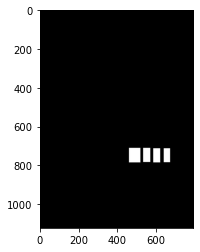

In [41]:
os.chdir("D:/Applied AI/")
plt.imshow(cv.imread(dataset['column_output'][0]))

### We have created our dataframe . We will save it so that we don't have to run the code again and again

In [42]:
os.chdir("D:/Applied AI/Case study 2/")
dataset.to_csv("dataset.csv")

In [429]:
list_heights = []
list_widths = []

for i in dataset['image'].values :
    image = i
    im_read = cv.imread(os.path.join('D:/Applied AI/', image))
    list_heights.append(im_read.shape[0])
    list_widths.append(im_read.shape[1])

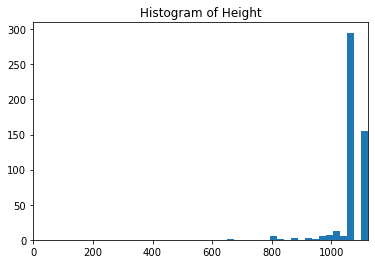

In [436]:
max_h = max(list_heights)
plt.hist(list_heights, bins = 20)
plt.xlim(0,max_h)
plt.title("Histogram of Height")
plt.show()

### Observation - Most of the images have height greater than 1000

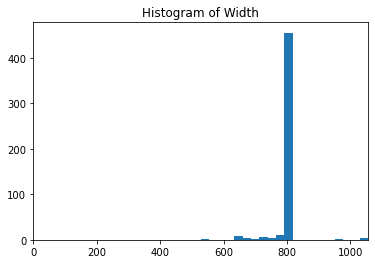

In [437]:
max_w = max(list_widths)
plt.hist(list_widths, bins = 20)
plt.xlim(0,max_w)
plt.title("Histogram of Width")
plt.show()

### Most of the images have width around 800

### Printing some random scanned images and their column and table masks 

In [421]:
x = dataset['table_output'][0]
path = os.path.join('D:/Applied AI/', x)

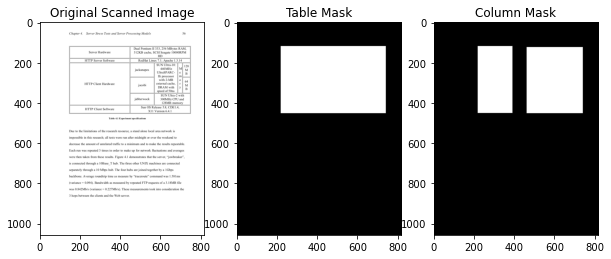

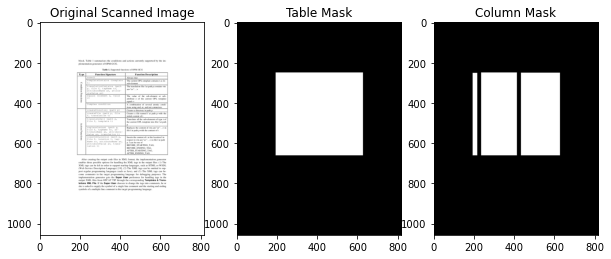

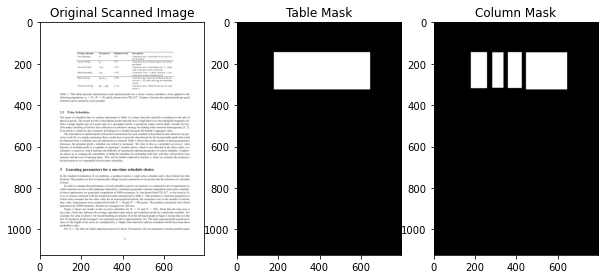

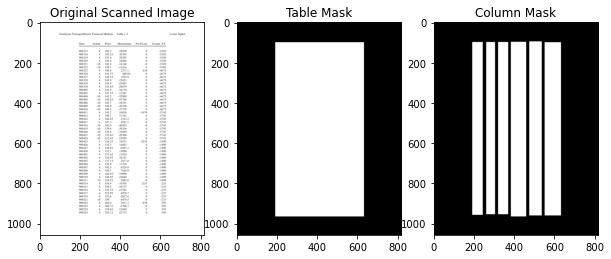

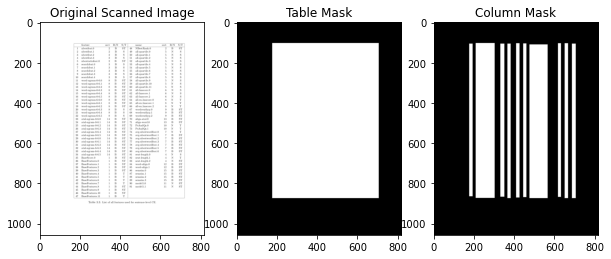

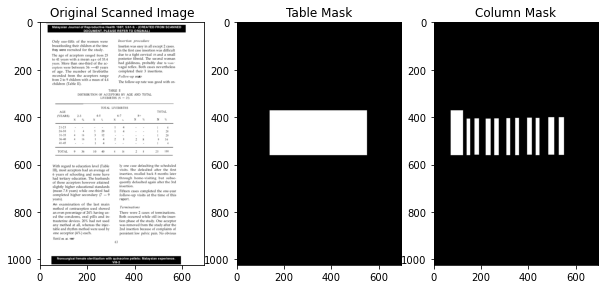

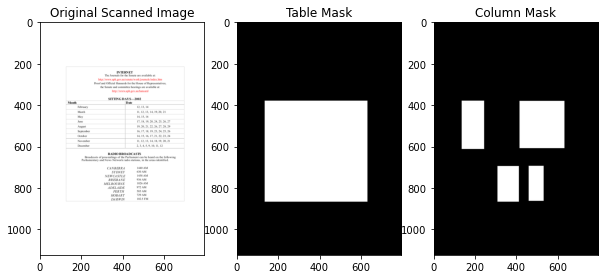

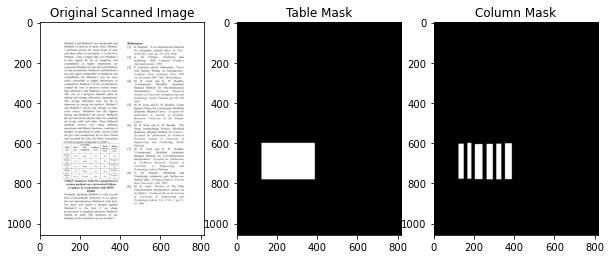

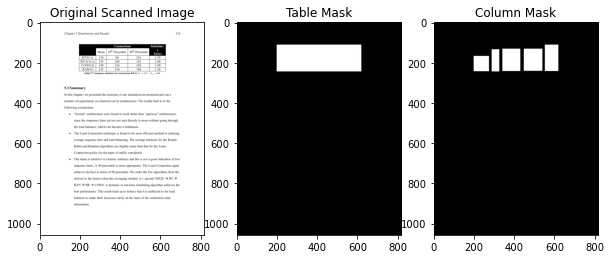

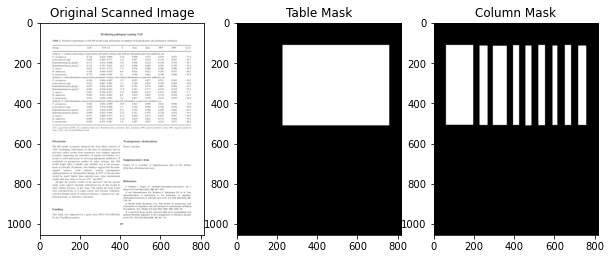

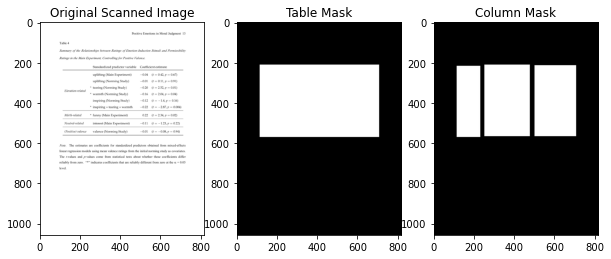

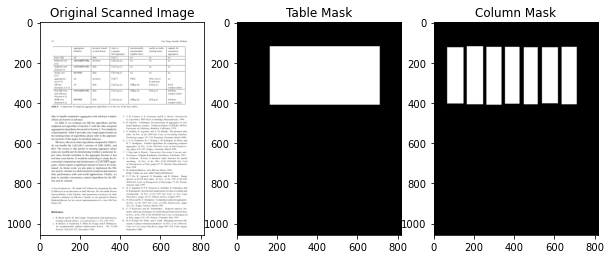

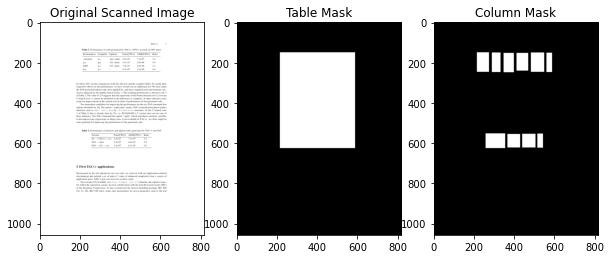

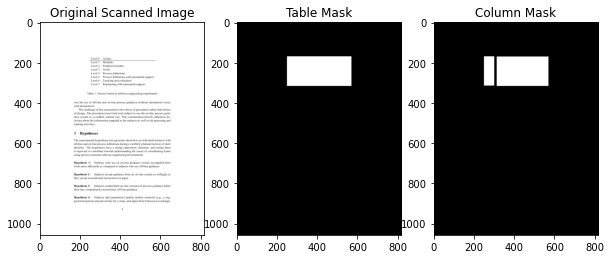

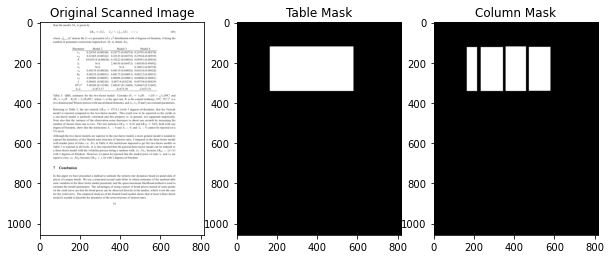

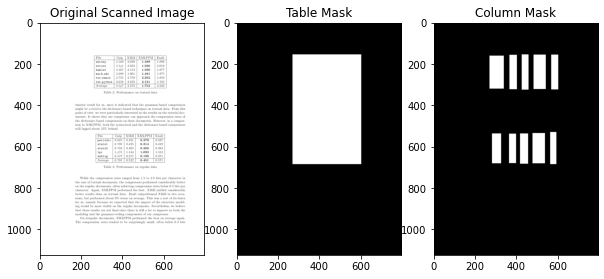

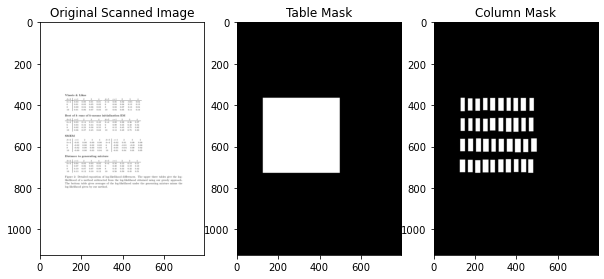

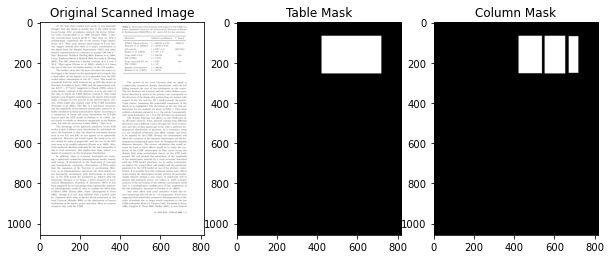

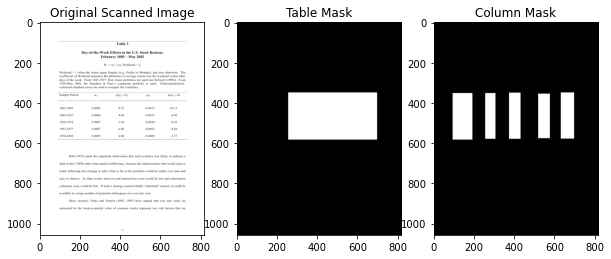

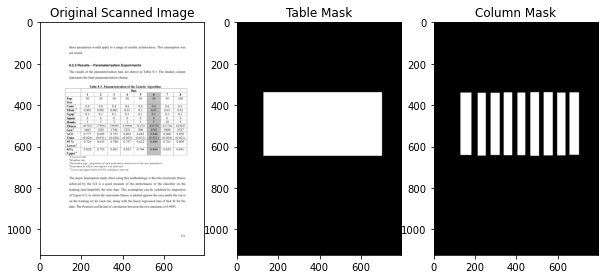

In [426]:
n = 20
ids = np.random.choice(np.arange(len(dataset)), size = n )

for i in ids :
    image = dataset['image'][i]
    im_read = cv.imread(os.path.join('D:/Applied AI/', image))
    
    plt.figure(figsize = (10,6))
    plt.subplot(131)
    plt.title("Original Scanned Image")
    plt.imshow(im_read)
    table = dataset['table_output'][i]
    tb_read = cv.imread(os.path.join('D:/Applied AI/', table))
    plt.subplot(132)
    plt.title("Table Mask")
    plt.imshow(tb_read)
    column = dataset['column_output'][i]
    cb_read = cv.imread(os.path.join('D:/Applied AI/', column))
    plt.subplot(133)
    plt.title("Column Mask")
    plt.imshow(cb_read)
    plt.show()

### We have created our final dataset for training .